# CFTC API Demo - Gold Net Positioning

**Author:** Dhruv Singh  
**Last Updated:** 2025-12-15  

## 1. Introduction

**Summary:** Pulls Commitments of Traders (COT) weekly futures data from the CFTC Public Reporting portal,
filters to Gold futures, engineers net positioning features by trader category, and visualizes positioning over time.  
**Data Source:** Disaggregated Futures Only report (url: publicreporting.cftc.gov).

## 2. Import Libraries

In [1]:
import os
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
pd.set_option('display.max_columns', None)

## 3. Data Collection

Pull the most recent 1000 rows for Gold

In [2]:
endpoint = "https://publicreporting.cftc.gov/resource/72hh-3qpy.json"

In [3]:
# Socrata-powered (“SODA”) APIs take a SoQL (SQL-like) query as a parameter
# common on many US gov/open-data portals
params = {
    "$select": "*",
    "$where": "commodity_name = 'GOLD' AND contract_market_name = 'GOLD'",
    "$order": "report_date_as_yyyy_mm_dd DESC",
    "$limit": 1000
}

# storing local copy of data to avoid re-pulling
cache_path = Path("../data/cftc_gold_cache.csv")
force_refresh = False

if cache_path.exists() and not force_refresh:
    df_gold_recent = pd.read_csv(cache_path)
else:
    r = requests.get(endpoint, params=params, timeout=30) # pulling data
    r.raise_for_status()  # fail fast on HTTP errors
    data = r.json()

    df_gold_recent = pd.DataFrame(data)
    df_gold_recent.to_csv(cache_path, index=False)

In [4]:
df_gold_recent.head()

,id,market_and_exchange_names,report_date_as_yyyy_mm_dd,yyyy_report_week_ww,contract_market_name,cftc_contract_market_code,cftc_market_code,cftc_region_code,cftc_commodity_code,commodity_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,swap__positions_spread_all,m_money_positions_long_all,m_money_positions_short_all,m_money_positions_spread,other_rept_positions_long,other_rept_positions_short,other_rept_positions_spread,tot_rept_positions_long_all,tot_rept_positions_short,nonrept_positions_long_all,nonrept_positions_short_all,open_interest_old,prod_merc_positions_long_1,prod_merc_positions_short_1,swap_positions_long_old,swap__positions_short_old,swap__positions_spread_old,m_money_positions_long_old,m_money_positions_short_old,m_money_positions_spread_1,other_rept_positions_long_1,other_rept_positions_short_1,other_rept_positions_spread_1,tot_rept_positions_long_old,tot_rept_positions_short_1,nonrept_positions_long_old,nonrept_positions_short_old,open_interest_other,prod_merc_positions_long_2,prod_merc_positions_short_2,swap_positions_long_other,swap__positions_short_other,swap__positions_spread_other,m_money_positions_long_other,m_money_positions_short_other,m_money_positions_spread_2,other_rept_positions_long_2,other_rept_positions_short_2,other_rept_positions_spread_2,tot_rept_positions_long_other,tot_rept_positions_short_2,nonrept_positions_long_other,nonrept_positions_short_other,change_in_open_interest_all,change_in_prod_merc_long,change_in_prod_merc_short,change_in_swap_long_all,change_in_swap_short_all,change_in_swap_spread_all,change_in_m_money_long_all,change_in_m_money_short_all,change_in_m_money_spread,change_in_other_rept_long,change_in_other_rept_short,change_in_other_rept_spread,change_in_tot_rept_long_all,change_in_tot_rept_short,change_in_nonrept_long_all,change_in_nonrept_short_all,pct_of_open_interest_all,pct_of_oi_prod_merc_long,pct_of_oi_prod_merc_short,pct_of_oi_swap_long_all,pct_of_oi_swap_short_all,pct_of_oi_swap_spread_all,pct_of_oi_m_money_long_all,pct_of_oi_m_money_short_all,pct_of_oi_m_money_spread,pct_of_oi_other_rept_long,pct_of_oi_other_rept_short,pct_of_oi_other_rept_spread,pct_of_oi_tot_rept_long_all,pct_of_oi_tot_rept_short,pct_of_oi_nonrept_long_all,pct_of_oi_nonrept_short_all,pct_of_open_interest_old,pct_of_oi_prod_merc_long_1,pct_of_oi_prod_merc_short_1,pct_of_oi_swap_long_old,pct_of_oi_swap_short_old,pct_of_oi_swap_spread_old,pct_of_oi_m_money_long_old,pct_of_oi_m_money_short_old,pct_of_oi_m_money_spread_1,pct_of_oi_other_rept_long_1,pct_of_oi_other_rept_short_1,pct_of_oi_other_rept_spread_1,pct_of_oi_tot_rept_long_old,pct_of_oi_tot_rept_short_1,pct_of_oi_nonrept_long_old,pct_of_oi_nonrept_short_old,pct_of_open_interest_other,pct_of_oi_prod_merc_long_2,pct_of_oi_prod_merc_short_2,pct_of_oi_swap_long_other,pct_of_oi_swap_short_other,pct_of_oi_swap_spread_other,pct_of_oi_m_money_long_other,pct_of_oi_m_money_short_other,pct_of_oi_m_money_spread_2,pct_of_oi_other_rept_long_2,pct_of_oi_other_rept_short_2,pct_of_oi_other_rept_spread_2,pct_of_oi_tot_rept_long_other,pct_of_oi_tot_rept_short_2,pct_of_oi_nonrept_long_other,pct_of_oi_nonrept_short_other,traders_tot_all,traders_prod_merc_long_all,traders_prod_merc_short_all,traders_swap_long_all,traders_swap_short_all,traders_swap_spread_all,traders_m_money_long_all,traders_m_money_short_all,traders_m_money_spread_all,traders_other_rept_long_all,traders_other_rept_short,traders_other_rept_spread,traders_tot_rept_long_all,traders_tot_rept_short_all,traders_tot_old,traders_prod_merc_long_old,traders_prod_merc_short_old,traders_swap_long_old,traders_swap_short_old,traders_swap_spread_old,traders_m_money_long_old,traders_m_money_short_old,traders_m_money_spread_old,traders_other_rept_long_old,traders_other_rept_short_1,traders_other_rept_spread_1,traders_tot_rept_long_old,traders_tot_rept_short_old,traders_tot_other,traders_prod_merc_long_other,traders_prod_merc_short_other,traders

In [5]:
df_gold_recent.columns

Index(['id', 'market_and_exchange_names', 'report_date_as_yyyy_mm_dd',
       'yyyy_report_week_ww', 'contract_market_name',
       'cftc_contract_market_code', 'cftc_market_code', 'cftc_region_code',
       'cftc_commodity_code', 'commodity_name',
       ...
       'conc_net_le_4_tdr_long_other', 'conc_net_le_4_tdr_short_other',
       'conc_net_le_8_tdr_long_other', 'conc_net_le_8_tdr_short_other',
       'contract_units', 'cftc_subgroup_code', 'commodity',
       'commodity_subgroup_name', 'commodity_group_name',
       'futonly_or_combined'],
      dtype='object', length=194)

In [6]:
df_gold_recent.shape

(1000, 194)

## 4. Data Cleaning & Preprocessing

In [7]:
date_col = "report_date_as_yyyy_mm_dd" # date column
df_gold_recent[date_col] = pd.to_datetime(df_gold_recent[date_col], errors="coerce") # converting to datetime type
df_gold_recent = df_gold_recent.sort_values(date_col).reset_index(drop=True) # sorting ascending by date
df_gold_recent[[date_col, "contract_market_name", "commodity_name"]].tail()

,report_date_as_yyyy_mm_dd,contract_market_name,commodity_name
995,2025-11-25,GOLD,GOLD
996,2025-12-02,GOLD,GOLD
997,2025-12-09,GOLD,GOLD
998,2025-12-16,GOLD,GOLD
999,2025-12-23,GOLD,GOLD


In [8]:
# listing all column names for producers / merchants, and swap dealers
[c for c in df_gold_recent.columns if "prod_merc_positions" in c or "swap" in c][:30]

['prod_merc_positions_long',
 'prod_merc_positions_short',
 'swap_positions_long_all',
 'swap__positions_short_all',
 'swap__positions_spread_all',
 'prod_merc_positions_long_1',
 'prod_merc_positions_short_1',
 'swap_positions_long_old',
 'swap__positions_short_old',
 'swap__positions_spread_old',
 'prod_merc_positions_long_2',
 'prod_merc_positions_short_2',
 'swap_positions_long_other',
 'swap__positions_short_other',
 'swap__positions_spread_other',
 'change_in_swap_long_all',
 'change_in_swap_short_all',
 'change_in_swap_spread_all',
 'pct_of_oi_swap_long_all',
 'pct_of_oi_swap_short_all',
 'pct_of_oi_swap_spread_all',
 'pct_of_oi_swap_long_old',
 'pct_of_oi_swap_short_old',
 'pct_of_oi_swap_spread_old',
 'pct_of_oi_swap_long_other',
 'pct_of_oi_swap_short_other',
 'pct_of_oi_swap_spread_other',
 'traders_swap_long_all',
 'traders_swap_short_all',
 'traders_swap_spread_all']

## 5. Feature engineering

**Net positions** are computed as Long - Short for each trader category.

In [9]:
# subsetting to long, short positions by trader category
cols = [
    "report_date_as_yyyy_mm_dd",
    "contract_market_name",
    "open_interest_all",
    "prod_merc_positions_long",
    "prod_merc_positions_short",
    "swap_positions_long_all",
    "swap__positions_short_all",
    "m_money_positions_long_all",
    "m_money_positions_short_all",
]
df = df_gold_recent[cols].copy()
df.head()

,report_date_as_yyyy_mm_dd,contract_market_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,m_money_positions_long_all,m_money_positions_short_all
0,2006-10-31,GOLD,323481,41086,109303,36081,59760,59985,39093
1,2006-11-07,GOLD,335036,39160,121982,31956,63590,76134,32604
2,2006-11-14,GOLD,356575,45125,133631,29696,64711,79157,29403
3,2006-11-21,GOLD,355430,40770,127929,31487,63304,77773,29323
4,2006-11-28,GOLD,349517,43198,123208,27309,65023,75457,30862


In [10]:
# ensuring correct variable types
df["report_date_as_yyyy_mm_dd"] = pd.to_datetime(df["report_date_as_yyyy_mm_dd"], errors="coerce") # datetime
num_cols = df.columns.drop(["report_date_as_yyyy_mm_dd", "contract_market_name"]) # numeric
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

#### Trader Categories:

- **Money Managers**: Hedge funds, CTAs, and asset managers.
- **Swap Dealers**: Large banks and dealers intermediating swaps and OTC derivatives.
- **Producers / Merchants**: Farmers, miners, energy producers, physical commodity firms.

Net positions tell us who is carrying risk and why.

In [11]:
# engineering net positioning by trader category
df["producer_net"] = df["prod_merc_positions_long"] - df["prod_merc_positions_short"]
df["swap_net"] = df["swap_positions_long_all"] - df["swap__positions_short_all"]
df["managed_money_net"] = df["m_money_positions_long_all"] - df["m_money_positions_short_all"]

In [12]:
df.tail()

,report_date_as_yyyy_mm_dd,contract_market_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,m_money_positions_long_all,m_money_positions_short_all,producer_net,swap_net,managed_money_net
995,2025-11-25,GOLD,432946,9950,56642,39044,233755,136979,27670,-46692,-194711,109309
996,2025-12-02,GOLD,418490,10094,58801,33860,240501,140143,19819,-48707,-206641,120324
997,2025-12-09,GOLD,432569,10463,59856,34556,247742,143383,19835,-49393,-213186,123548
998,2025-12-16,GOLD,471093,16057,60306,31970,262079,152873,20277,-44249,-230109,132596
999,2025-12-23,GOLD,492103,17158,68442,30143,262385,160581,24311,-51284,-232242,136270


## 6. Visualization

Net positioning over time for Producer/Merchant, Swap Dealers, and Managed Money.

In [13]:
plt.style.use('Solarize_Light2')

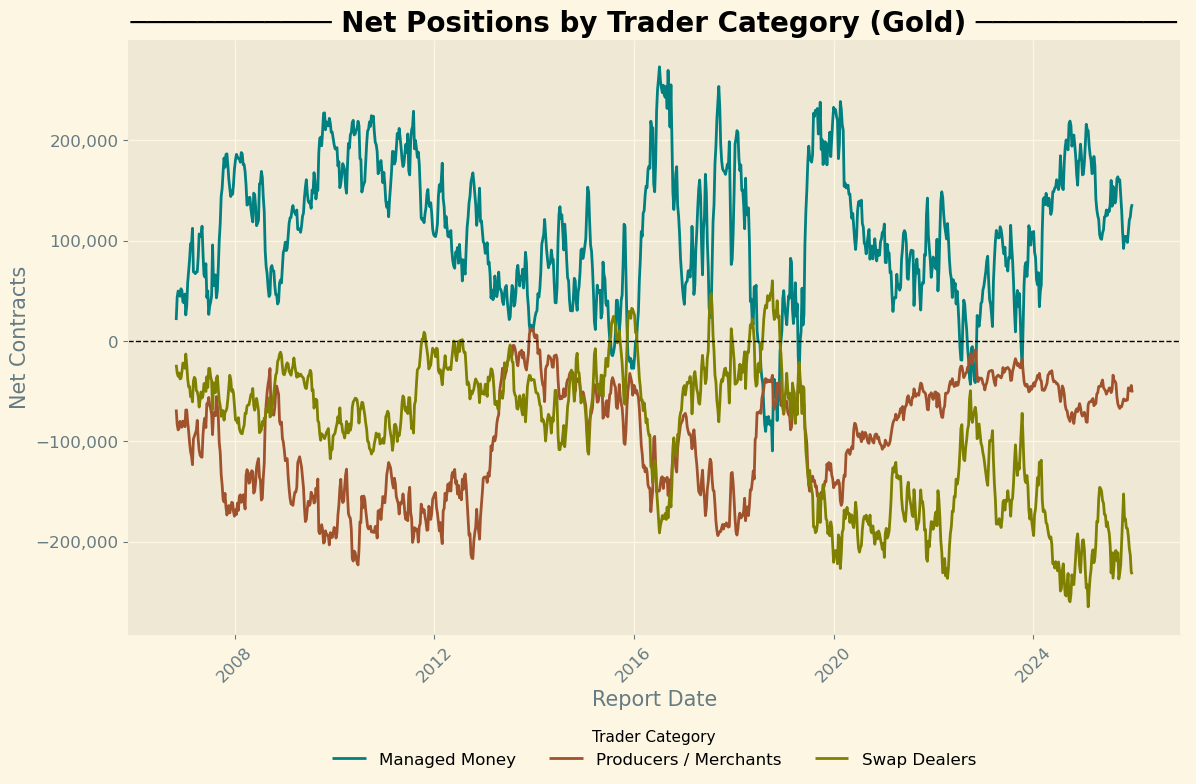

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

# net positions by trader category
ax.plot(df["report_date_as_yyyy_mm_dd"], df["managed_money_net"], label="Managed Money",
        linewidth=2, color="teal")
ax.plot(df["report_date_as_yyyy_mm_dd"], df["producer_net"], label="Producers / Merchants",
        linewidth=2, color="sienna")
ax.plot(df["report_date_as_yyyy_mm_dd"], df["swap_net"], label="Swap Dealers",
        linewidth=2, color="olive")

# +ve = net long, -ve = net short
ax.axhline(0, color="black", linewidth=1, linestyle="--")

# labels
ax.set_title(" ──────────── Net Positions by Trader Category (Gold) ──────────── ",
             fontsize=20, fontweight="bold")
ax.set_xlabel("Report Date", fontsize=15)
ax.set_ylabel("Net Contracts", fontsize=15)

 # adding comma to y axis ticks
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.tick_params(axis="x", labelsize=12, rotation=45)
ax.tick_params(axis="y", labelsize=12)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# pinning legend to bottom
leg = ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=3,
                frameon=False, fontsize=12, title="Trader Category", title_fontsize=11)

plt.tight_layout()
plt.savefig("../assets/gold_net_positions.png", dpi=300, bbox_inches="tight")
plt.show()

## 9. Conclusions & Next Steps
- When Managed Money net positioning rises sharply, Producers/Swap Dealers often take the other side.
- Future work: Parameterize the commodity/contract selection (reusable query template)